In [1]:
import numpy as np
import tensorflow as tf

from skimage import data
from skimage.transform import resize

from scipy.misc import imresize

from time import time

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

import IPython.display as ipyd

import gif    # Check CADL directory

In [2]:
tf.reset_default_graph()

In [2]:
def flatten(x, name=None, reuse=None):
    """Flatten Tensor to 2-dimensions.

    Parameters
    ----------
    x : tf.Tensor
        Input tensor to flatten.
    name : None, optional
        Variable scope for flatten operations

    Returns
    -------
    flattened : tf.Tensor
        Flattened tensor.
    """
    with tf.variable_scope('flatten'):
        dims = x.get_shape().as_list()
        if len(dims) == 4:
            flattened = tf.reshape(
                x,
                shape=[-1, dims[1] * dims[2] * dims[3]])
        elif len(dims) == 2 or len(dims) == 1:
            flattened = x
        else:
            raise ValueError('Expected n dimensions of 1, 2 or 4.  Found:',
                             len(dims))

        return flattened

In [4]:
"""
scp = "fully_connected"

g = tf.Graph()
with g.as_default():    
    X = tf.placeholder(dtype=tf.float32, shape=[None, 2], name="X")
"""

'\nscp = "fully_connected"\n\ng = tf.Graph()\nwith g.as_default():    \n    X = tf.placeholder(dtype=tf.float32, shape=[None, 2], name="X")\n'

In [3]:
def linear(X, n_outputs, scope=None, activation=None, reuse=None):
    
    if X.get_shape() != 2:
        X = flatten(X)
        
    n_inputs = X.get_shape().as_list()[1]
    
    with tf.variable_scope(scope or "fully_connected", reuse=reuse):

        weights = tf.get_variable(
            name="weights",
            dtype=tf.float32,
            shape=[n_inputs, n_outputs],
            initializer=tf.random_normal_initializer(stddev=0.1)
        )

        biases = tf.get_variable(
            name="biases",
            dtype=tf.float32,
            shape=[n_outputs],
            initializer=tf.constant_initializer(value=0)
        )

        hidden = tf.matmul(X, weights) + biases
        
        if activation:
            hidden = activation(hidden)
            
        return hidden

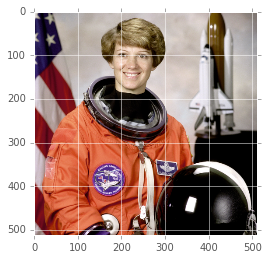

In [4]:
img = data.astronaut()
#img = imresize(img, size=(100, 100))
#img = imresize(img, size=(64, 64))

plt.imshow(img);

In [5]:
def im_split(img):
    # To store positions (x, y)
    xs = []
    
    # to store Colors (R, G, B)
    ys = []
    
    for row_i in range(img.shape[0]):
        for col_i in range(img.shape[1]):
            xs.append([row_i, col_i])
            ys.append(img[row_i, col_i])
            
    xs = np.array(xs)
    ys = np.array(ys)
    
    return xs, ys

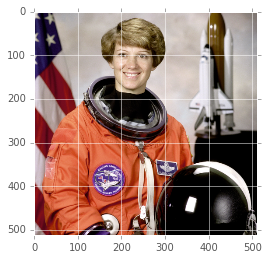

In [6]:
xs, ys = im_split(img)

plt.imshow(ys.reshape(img.shape));

### Normalizing
So the NN won't focus on the position of the pixel (color), but rather on the disribution

In [7]:
xs_norm = (xs - np.mean(xs)) / np.std(xs)

print(np.min(xs_norm), np.max(xs_norm))

-1.72867119302 1.72867119302


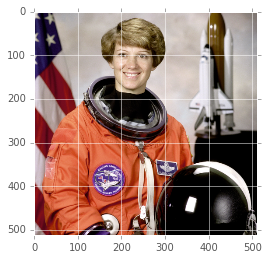

In [8]:
ys_norm = ys / 255.0

plt.imshow(ys_norm.reshape(img.shape));

# Build the graph:

In [79]:
tf.reset_default_graph()


X = tf.placeholder(name='X', shape=[None, 2], dtype=tf.float32)
Y = tf.placeholder(name='Y', shape=[None, 3], dtype=tf.float32)


n_neurons = 64
layers = [2, n_neurons, n_neurons, n_neurons, n_neurons, n_neurons, n_neurons, 3]
activ = tf.nn.relu

# Specify "reuse=True" if errors or try resest the default graph

actual_layer = X
for layer_i in range(1, len(layers)):
    actual_layer = linear(
        X=actual_layer,
        activation=activ if layer_i < (len(layers) - 1) else None,
        n_outputs=layers[layer_i],
        scope=("layer_" + str(layer_i))
    )
    
Y_pred = actual_layer

In [80]:
assert(X.get_shape().as_list() == [None, 2])
assert(Y.get_shape().as_list() == [None, 3])
assert(Y_pred.get_shape().as_list() == [None, 3])

###### l1 vs l2 loss:

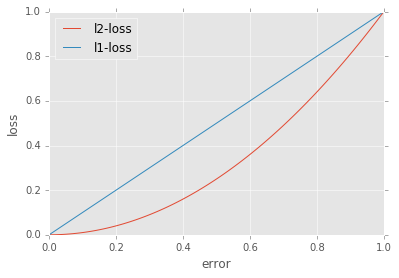

In [58]:
error = np.linspace(0, 1, 100)

plt.plot(error, error**2, label="l2-loss")
plt.plot(error, np.abs(error), label="l1-loss")

plt.xlabel("error")
plt.ylabel("loss")

plt.legend(loc="upper left");

In [81]:
# l1 loss
#cost = tf.abs(x=Y - Y_pred)

#l2 loss
cost = tf.squared_difference(x=Y, y=Y_pred)

cost = tf.reduce_sum(cost, axis=1)
cost = tf.reduce_mean(cost)

assert(cost.get_shape().as_list() == [])

In [82]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

n_iterations = 200
batch_size = 50

sess = tf.Session()

# Training day:

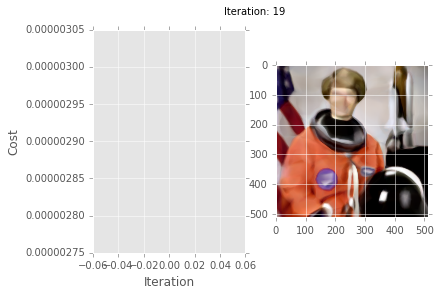

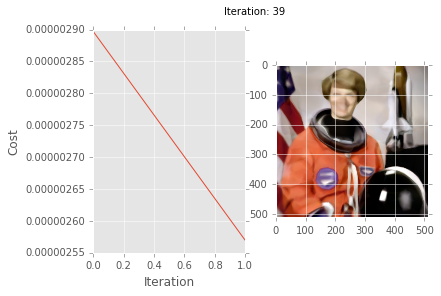

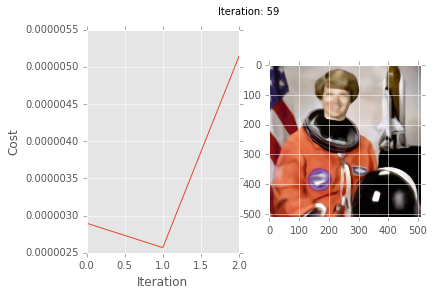

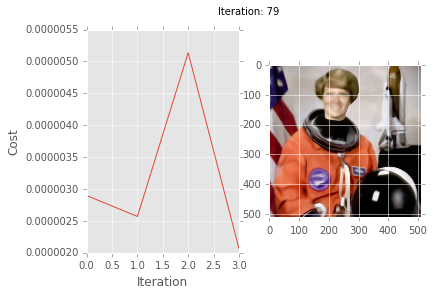

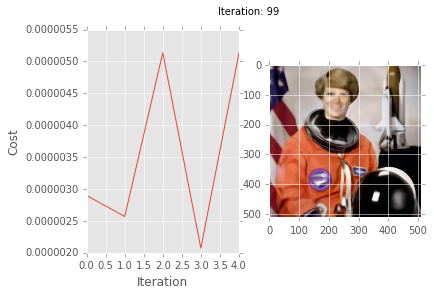

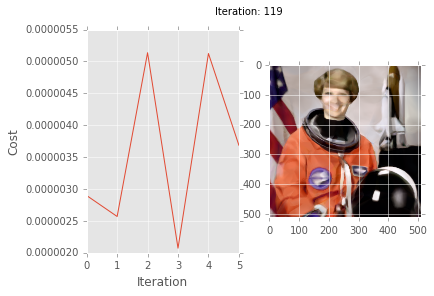

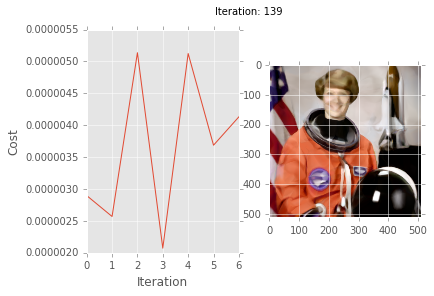

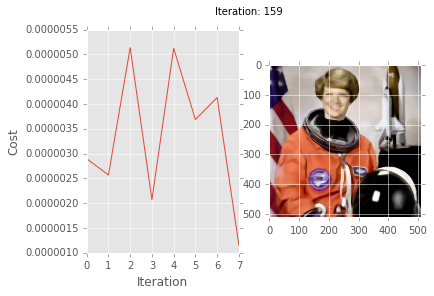

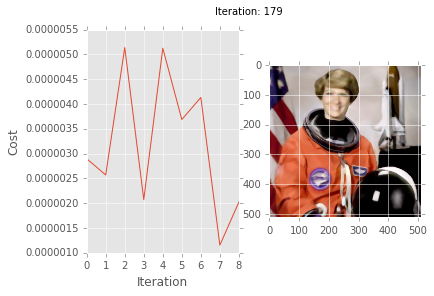

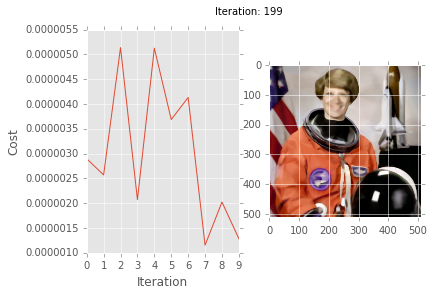



Duration: 2207.50 sec


In [136]:
sess.run(tf.global_variables_initializer())

imgs = []
costs = []

gif_step = n_iterations // 10
step_i = 0


tic = time()

for iter_i in range(n_iterations):
    idxs = np.random.permutation(range(len(xs)))
    n_batches = len(xs) // batch_size
    
    for batch_i in range(n_batches):
        idxs_i = idxs[batch_i * batch_size : (batch_i + 1) * batch_size]
        
        train_cost = sess.run(
            fetches=[cost, optimizer],
            feed_dict={
                X: xs_norm[idxs_i],
                Y: ys_norm[idxs_i]
            }
        )[0]
        
    # Every "gif_step" iters, draw a prediction, and try to recreate the image
    if (iter_i + 1) % gif_step == 0:     # The +1 is just to include the last iter (y)
        costs.append(train_cost / n_batches)
        ys_pred = Y_pred.eval(feed_dict={X: xs_norm}, session=sess)
        
        img_pred = np.clip(a=(ys_pred * 255).reshape(img.shape), a_min=0, a_max=255).astype(np.uint8)
        imgs.append(img_pred)
        
        # Plot the cost
        fig, ax = plt.subplots(1, 2)
        ax[0].plot(costs)
        ax[0].set_xlabel("Iteration")
        ax[0].set_ylabel("Cost")
        ax[1].imshow(img_pred)
        fig.suptitle("Iteration: {}".format(iter_i))
        plt.show()

        
        
toc = time()
print("\n\nDuration: {:.2f} sec".format(toc - tic))

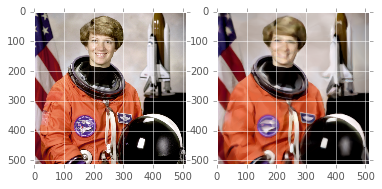

In [139]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(img)
axs[1].imshow(imgs[-1]);

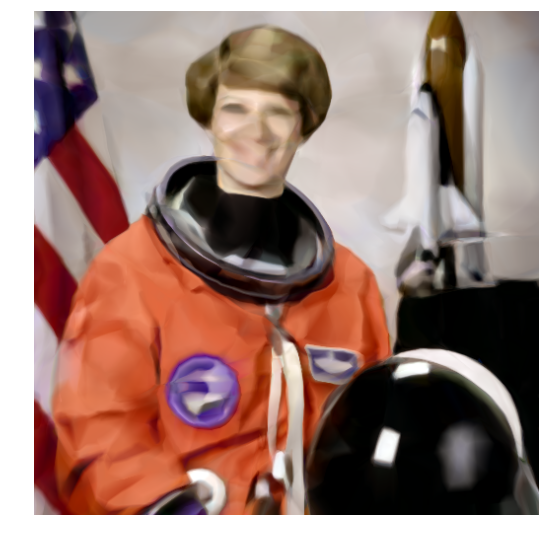

In [146]:
gif.build_gif(imgs, saveto="anim.gif", interval=0.1)
ipyd.Image(url='anim.gif?{}'.format(np.random.rand()), height=500, width=500)

### Wrapping the whole stuff in a func:

In [28]:
def train(x_train, y_train, optimizer, loss, scope=None, n_iterations=100, batch_size=50):
    with tf.Session() as sess, tf.variable_scope(scope or "new_train"):
        
        sess.run(tf.global_variables_initializer())

        imgs = []
        costs = []

        gif_step = n_iterations // 10 if (n_iterations >= 10) else 1
        step_i = 0


        tic = time()

        for iter_i in range(n_iterations):
            idxs = np.random.permutation(range(len(x_train)))
            n_batches = len(x_train) // batch_size

            for batch_i in range(n_batches):
                idxs_i = idxs[batch_i * batch_size : (batch_i + 1) * batch_size]

                train_cost = sess.run(
                    fetches=[loss, optimizer],
                    feed_dict={
                        X: x_train[idxs_i],
                        Y: y_train[idxs_i]
                    }
                )[0]

            # Every "gif_step" iters, draw a prediction, and try to recreate the image
            if (iter_i + 1) % gif_step == 0:     # The +1 is just to include the last iter (y)
                costs.append(train_cost / n_batches)
                ys_pred = Y_pred.eval(feed_dict={X: x_train}, session=sess)

                if x_train.std() == 1.0:
                    ys_pred = ys_pred * 255
                    
                img_pred = np.clip(a=ys_pred.reshape(img.shape), a_min=0, a_max=255).astype(np.uint8)
                imgs.append(img_pred)

                # Plot the cost
                fig, ax = plt.subplots(1, 2)
                ax[0].plot(costs)
                ax[0].set_xlabel("Iteration")
                ax[0].set_ylabel("Cost")
                ax[1].imshow(img_pred)
                fig.suptitle("Iteration: {}".format(iter_i + 1))
                plt.show()

                
        toc = time()
        print("\n\nDuration: {:.2f} sec".format(toc - tic))
        
        return imgs, costs

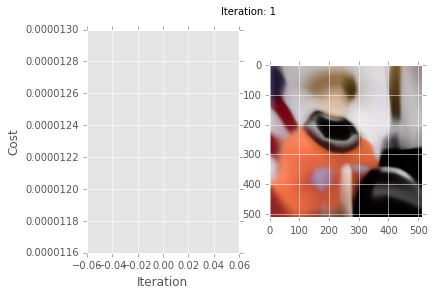



Duration: 15.59 sec


In [78]:
train(xs_norm, ys_norm, optimizer=optimizer, loss=cost, n_iterations=1, scope="train");

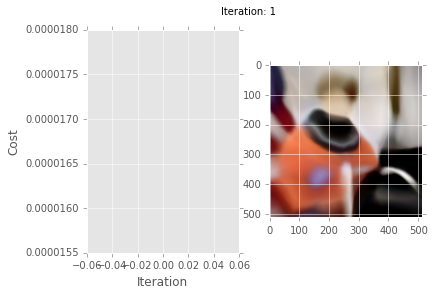



Duration: 12.80 sec


In [83]:
train(xs_norm, ys_norm, optimizer=optimizer, loss=cost, n_iterations=1, scope="train");